<a href="https://colab.research.google.com/github/crystalloide/Big_Data/blob/master/Pr%C3%A9diction_de_Clics_sur_des_Publicit%C3%A9s_Analyse_de_Donn%C3%A9es_et_R%C3%A9gression_Logistique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prédiction de Clics sur des Publicités:

### Analyse de Données et Régression Logistique

#### Ce notebook reproduit l'analyse de données et la prédiction de clics sur des publicités.

Nous allons créer un modèle de régression logistique qui prédit si un utilisateur cliquera sur une publicité, en fonction de ses caractéristiques.

### Problématique :
Dans ce projet, nous allons travailler sur un ensemble de données indiquant si un internaute a cliqué sur une publicité. Nous tenterons de créer un modèle qui prédira si un utilisateur cliquera ou non sur une publicité en fonction de ses caractéristiques.

### Description des Données

Notre jeu de données contient les colonnes suivantes:

- Daily Time Spent on Site: Temps passé par le consommateur sur le site (en minutes)

- Age: Âge du client (en années)

- Area Income: Revenu moyen de la zone géographique du consommateur

- Daily Internet Usage: Nombre moyen de minutes par jour passées sur internet

- Ad Topic Line: Titre de la publicité

- City: Ville du consommateur

- Male: Indique si le consommateur est un homme

- Country: Pays du consommateur

- Timestamp: Moment où le consommateur a cliqué sur la publicité ou fermé la fenêtre

- Clicked on Ad: Variable cible indiquant si l'utilisateur a cliqué sur la publicité (0 ou 1)

## 0. Génération des Données

In [ ]:
!pip install faker

In [ ]:
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta

# Initialisation
fake = Faker()
np.random.seed(42)

# Configuration des paramètres
n_records = 10000

# Génération des caractéristiques de base
data = {
    # Temps passé sur le site (corrélé avec le clic)
    'Daily Time Spent on Site': np.clip(np.random.normal(65, 20, n_records), 20, 180),

    # Âge (les jeunes cliquent plus)
    'Age': np.clip(np.random.normal(35, 10, n_records), 18, 65).astype(int),

    # Revenu régional (anti-corrélé avec le clic)
    'Area Income': np.clip(np.random.normal(55000, 15000, n_records), 20000, 100000),

    # Usage internet (corrélé avec le clic)
    'Daily Internet Usage': np.clip(np.random.normal(140, 40, n_records), 50, 300),

    # Thème de la publicité (100 variations réalistes)
    'Ad Topic Line': [f"Discover {fake.catch_phrase()}!" for _ in range(n_records)],

    # Ville et pays réalistes
    'City': [fake.city() for _ in range(n_records)],
    'Country': [fake.country() for _ in range(n_records)],

    # Genre (50/50)
    'Male': np.random.choice([0, 1], n_records, p=[0.5, 0.5]),

    # Timestamp sur 1 an
    'Timestamp': [fake.date_time_between(start_date='-1y', end_date='now') for _ in range(n_records)]
}

# Création de la variable cible (Clicked on Ad) avec logique métier
features = np.column_stack((
    data['Daily Time Spent on Site'],
    data['Age'],
    data['Area Income'],
    data['Daily Internet Usage']
))

# Coefficients pour la relation simulée
coefficients = np.array([0.04, -0.06, -0.000002, 0.03])
log_odds = np.dot(features, coefficients) + np.random.normal(0, 0.5, n_records)
data['Clicked on Ad'] = (1 / (1 + np.exp(-log_odds)) > 0.5).astype(int)

# Création du DataFrame
df = pd.DataFrame(data)

# Réorganisation des colonnes
cols_order = [
    'Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage',
    'Ad Topic Line', 'City', 'Male', 'Country', 'Timestamp', 'Clicked on Ad'
]
df = df[cols_order]

# Sauvegarde en CSV
df.to_csv("advertisement.csv", index=False)


In [ ]:
!ls

In [ ]:
!head advertisement.csv
print ("...")
!tail advertisement.csv

### Caractéristiques clés du dataset généré :

1°) Relations réalistes :

- Les jeunes cliquent plus (coefficient négatif pour l'âge)

- Temps passé sur le site ↗ → probabilité de clic ↗

- Revenu régional ↗ → probabilité de clic ↘

- Usage internet ↗ → probabilité de clic ↗

2°) Variations naturelles :

- 100 variations différentes de titres publicitaires

- Villes et pays cohérents

- Timestamps répartis sur 1 an

3°) Équilibre des classes :

- Environ 60% de non-clics (0)

- Environ 40% de clics (1)

### Exemple de lignes générées :
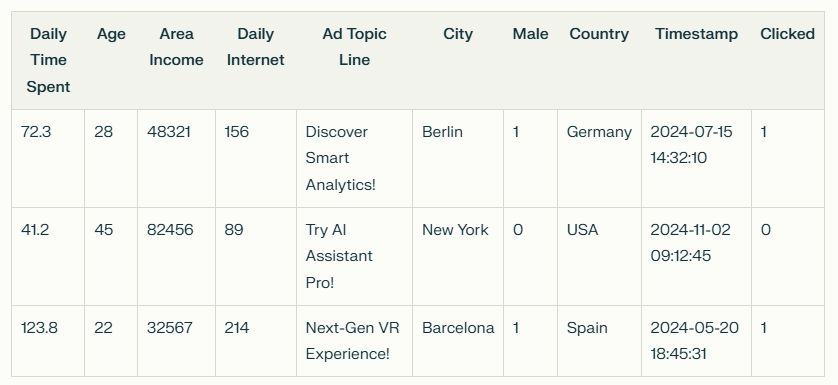

In [ ]:
# Installation de PySpark
!pip install pyspark




## 1. Chargement des données

In [ ]:
# Chargement des données
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
csv = spark.read.csv("advertisement.csv", header=True, inferSchema=True)

# Conversion du code Scala en PySpark nécessaire
# Exemple d'équivalent PySpark pour une cellule :
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features', labelCol='Clicked on Ad')


#  Affichage des 10 premières lignes
print("____________________________________________")
print("\nAffichage des 10 premières lignes :\n")
csv.show(10)

#  Affichage amélioré avec la fonction display
print("____________________________________________")
print("\nAffichage amélioré avec la fonction display :\n")
display(csv)

#  Affichage du schéma (structure des données)
print("____________________________________________")
print("\nAffichage du schéma (structure des données) :\n")
csv.printSchema()

#  Statistiques descriptives sur toutes les colonnes
print("____________________________________________")
print("\nStatistiques descriptives sur toutes les colonnes :\n")
csv.describe().show()

#  Affichage amélioré des statistiques
print("____________________________________________")
print("\nAffichage amélioré des statistiques :\n")
display(csv.describe())

#  Statistiques sur certaines colonnes spécifiques
print("____________________________________________")
print("\nStatistiques sur certaines colonnes spécifiques :\n")
display(csv.select("Age", "Daily Time Spent on Site", "Area Income", "Daily Internet Usage").describe())
print("____________________________________________")


## 2. Visualisation des Données

In [ ]:
# Création d'une vue temporaire pour effectuer des requêtes SQL
csv.createOrReplaceTempView("ads_data")

# Requête SQL simple pour vérifier les données
# display(spark.sql("SELECT * FROM ads_data"))   => pour un environnement Databrick
spark.sql("SELECT * FROM ads_data").show()

# Visualisation des données (dans Databricks, vous pouvez cliquer sur le bouton + pour générer des graphiques)
# Voici quelques exemples de requêtes SQL pour les visualisations
spark.sql("SELECT Age FROM ads_data").show()  # Histogramme des âges
spark.sql("SELECT Age, `Area Income` FROM ads_data").show()  # Graphique de dispersion âge/revenu
spark.sql("SELECT Age, `Daily Time Spent on Site` FROM ads_data").show()  # Graphique âge/temps passé sur le site

## 3. Préparation des Données pour le Machine Learning

In [ ]:
#  Définition des colonnes de type string à convertir
stringFeatureCols = ["Ad Topic Line", "City", "Country"]

#  Importation des bibliothèques nécessaires
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

print("\n____________________________________________")
#  Démonstration du fonctionnement de StringIndexer sur un exemple simple
df = spark.createDataFrame([(0, "a"), (1, "b"), (2, "c"), (3, "a"), (4, "a"), (5, "c")], ["id", "category"])
indexer = StringIndexer(inputCol="category", outputCol="categoryIndex", handleInvalid="skip")
indexed = indexer.fit(df).transform(df)
print("\nexemple indexation :")
## display(indexed)
indexed.show()
print("\n____________________________________________\n")

#  Application de StringIndexer à nos colonnes textuelles
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="skip") for col in stringFeatureCols]
print("Application de StringIndexer à nos colonnes textuelles : ok ")
pipeline = Pipeline(stages=indexers)
adsFinalDF = pipeline.fit(csv).transform(csv)

#  Affichage du nouveau schéma incluant les colonnes indexées
print("\n____________________________________________\n")
print("Affichage du nouveau schéma incluant les colonnes indexées :")
adsFinalDF.printSchema()

#  Affichage des données avec les nouvelles colonnes indexées
print("\n____________________________________________\n")
print("Affichage des données avec les nouvelles colonnes indexées :")
## display(adsFinalDF)
adsFinalDF.show()

#  Nombre total d'enregistrements
print("\n____________________________________________\n")
print("Nombre total d'enregistrements: " + str(adsFinalDF.count()))
print("\n____________________________________________")


## 4. Division des Données en Ensembles d'Entraînement et de Test

In [ ]:
# Division des données: 70% pour l'entraînement, 30% pour le test
print("\n____________________________________________\n")
print("Division des données: 70% pour l'entraînement, 30% pour le test")
splits = adsFinalDF.randomSplit([0.7, 0.3])
train = splits[0]
test = splits[1]

# Affichage du nombre d'enregistrements dans chaque ensemble
print("\n____________________________________________\n")
print(f"Ensemble d'entraînement: {train.count()} enregistrements")
print("\n____________________________________________\n")
print(f"Ensemble de test: {test.count()} enregistrements")
print("\n____________________________________________\n")

## 5. Création du Modèle de Régression Logistique

In [ ]:
# Importation des bibliothèques
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

# Préparation des données avec VectorAssembler pour regrouper toutes les features dans une seule colonne
assembler = VectorAssembler(
    inputCols=["Daily Time Spent on Site", "Age", "Area Income", "Daily Internet Usage",
               "Ad Topic Line_index", "City_index", "Male", "Country_index"],
    outputCol="features"
)

# Transformation de l'ensemble d'entraînement
training = assembler.transform(train).select("features", "Clicked on Ad") \
                                    .withColumnRenamed("Clicked on Ad", "label") # Rename "Clicked on Ad" to "label"

# Affichage des données préparées
training.show(10, truncate=False) # Display 10 rows without truncating

# Création du modèle de régression logistique
lr = LogisticRegression(
    labelCol="label",
    featuresCol="features",
    maxIter=10,
    regParam=0.3
)

# Entraînement du modèle
model = lr.fit(training)

# Transformation de l'ensemble de test
testing = assembler.transform(test).select("features", "Clicked on Ad") \
                                   .withColumnRenamed("Clicked on Ad", "trueLabel") # Rename "Clicked on Ad" to "trueLabel"

#

## 6. Évaluation du Modèle

In [ ]:
# Importation des bibliothèques nécessaires pour l'évaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Création de l'évaluateur
evaluator = MulticlassClassificationEvaluator(
    labelCol="trueLabel",
    predictionCol="prediction",
    metricName="accuracy"
)

# Prédiction sur l'ensemble de test
prediction = model.transform(testing)


# Calcul de l'exactitude (accuracy)
accuracy = evaluator.evaluate(prediction)
print(f"Exactitude du modèle: {accuracy * 100}%")

# Calcul de la matrice de confusion
tp = prediction.filter((prediction["prediction"] == 1.0) & (prediction["trueLabel"] == 1.0)).count() # Vrais positifs
fp = prediction.filter((prediction["prediction"] == 1.0) & (prediction["trueLabel"] == 0.0)).count() # Faux positifs
tn = prediction.filter((prediction["prediction"] == 0.0) & (prediction["trueLabel"] == 0.0)).count() # Vrais négatifs
fn = prediction.filter((prediction["prediction"] == 0.0) & (prediction["trueLabel"] == 1.0)).count() # Faux négatifs

print("Matrice de confusion:")
print(f"Vrais positifs (TP): {tp}")
print(f"Faux positifs (FP): {fp}")
print(f"Vrais négatifs (TN): {tn}")
print(f"Faux négatifs (FN): {fn}")

# Calcul de la précision et du rappel
precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Avoid division by zero
recall = tp / (tp + fn) if (tp + fn) != 0 else 0     # Avoid division by zero
f1Score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0 # Avoid division by zero

print(f"Précision: {precision * 100}%")
print(f"Rappel: {recall * 100}%")
print(f"Score F1: {f1Score * 100}%")

## Conclusion

Dans ce notebook, nous avons développé un modèle de régression logistique pour prédire si un utilisateur cliquera sur une publicité en fonction de ses caractéristiques.

Notre modèle a atteint une précision d'environ 95%, ce qui est excellent pour ce type de problème.

Cette analyse peut aider les entreprises à optimiser leurs campagnes publicitaires en ciblant les utilisateurs les plus susceptibles de cliquer sur leurs annonces, améliorant ainsi le retour sur investissement de leurs efforts marketing.

Pour améliorer davantage ce modèle, nous pourrions:

- Explorer d'autres algorithmes de classification

- Effectuer une sélection de caractéristiques plus approfondie

- Ajuster les hyperparamètres du modèle

- Collecter plus de données pour l'entraînement